In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from keras.engine import sequential
import numpy as np
from string import punctuation
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as k
import tensorflow.keras.layers as l
from sklearn.model_selection import train_test_split
import random


features_csv = pd.read_csv('features.csv')
labels_csv = pd.read_csv('lables.csv') # not labels
my_labels = np.array(labels_csv['Delta'].tolist())

tweets = features_csv['clean_text'].tolist()

for s in range(len(tweets)):
    # print(type(tweets[s]), type("\n"))
    tweets[s] = str(tweets[s]) + "\n"
    # print(s)
data = np.array(tweets)

prior_days = features_csv['five_prior_delta'].tolist()
pdays = []
#print(prior_days[0])
#context = features_csv.five_prior_delta.apply(pd.Series)
#context.columns = ["five", 'four', 'three', 'two', 'one']
#context = pd.DataFrame(prior_days, columns = ["five",'four','three','two','one'])
#context[['comments','likes','retweets','trading_day']] = features_csv[['Comments','Likes','Retweets','trading_day']]

#context.info()
for days in prior_days:
    string_days = days.strip('][').split(', ')
    for i in range(len(string_days)):
        string_days[i] = float(string_days[i])
    pdays.append(string_days)

context = np.array(pdays)


"""for i in range(data.shape[0]):
  data[i] = data[i].lower()
  # print(data[i])"""

all_text = ''.join([c for c in data if c not in punctuation])
# print(type(all_text))
reviews_split = all_text.split('\n')[0:-1]


all_text2 = ' '.join(reviews_split)
# create a list of words
words = all_text2.split()
# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
# print("SPLITHERE", reviews_split)
sorted_words = count_words.most_common(total_words)

vocab_to_int = {w:i for i, (w,c) in enumerate(sorted_words)}
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
# print(vocab_to_int)

reviews_int = []
for review in reviews_split:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)
# print(type(reviews_int), reviews_int)
max_words = np.max(np.max(reviews_int))
# print(max_words)
max_len = 0
for review in reviews_int:
    if len(review) > max_len:
        max_len = len(review)
print(max_len)

reviews_len = [len(x) for x in reviews_int]
#pd.Series(reviews_len).hist()
#plt.show()
#pd.Series(reviews_len).describe()

# get rid of long and short reviews
# reviews_int = [reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
# my_labels = [my_labels[i] for i, l in enumerate(reviews_len) if l> 0 ]




def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features
features = np.array(pad_features(reviews_int, max_len))
len_feat = len(features)
my_labels = np.array(my_labels)


rs = random.randint(0,100)
print(features.shape, my_labels.shape)
train_x, test_x, train_y, test_y = train_test_split(features, my_labels, test_size=0.2, random_state=rs)
train_context, test_context, train_y, test_y = train_test_split(context, my_labels, test_size=0.2, random_state=rs)

from sklearn.preprocessing import QuantileTransformer,Normalizer, MinMaxScaler

norm = QuantileTransformer(output_distribution='normal')
train_context = norm.fit_transform(train_context)
test_context = norm.transform(test_context)
print(labels_csv.columns[0:2])
labels_csv.drop(labels_csv.columns[0:2], axis=1, inplace=True)



#labels_trans = MinMaxScaler()
#train_lbs, test_lbs = train_test_split(labels_csv, test_size=0.2, random_state=rs)

#train_y = labels_trans.fit_transform(train_lbs)
#test_y = labels_trans.transform(test_lbs)



train_x = train_x * 100
test_y = test_y * 100


'''
model = sequential()
model.add(Embedding(MAX_WORDS, OUTPUT_SIZE, input_length=example_length)) #(33,8,10)
model.add(LSTM)
model.add(dropout)
model.add(LSTM)
model.add(dropout)
# however many denses we want, concatenate with context model
dense
dropout
dense
compile
fit
evaluate
'''

print(train_x.shape, train_context.shape, train_y.shape)
print(test_x.shape, test_context.shape, test_y.shape)
# print(valid_x.shape, valid_context.shape, valid_y.shape)
in1 = l.Input(shape=[max_len])
in2 = l.Input(shape=[5])

# number of possible words, desired output shape, padded input length
m1 = l.Embedding(max_words, 8, input_length=max_len)(in1)
m1 = l.LSTM(4)(m1) # can be replaced with SimpleRNN
m1 = l.Dense(2, activation='relu')(m1)
m1 = l.BatchNormalization()(m1)
 
m2 = l.Dense(2, activation='relu')(in2)
m2 = l.BatchNormalization()(m2)

m = l.concatenate([m1,m2])
u = l.Dense(1, activation='tanh')(m)

model = k.Model(inputs=[in1, in2], outputs=u)

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit([train_x, train_context], train_y, validation_split=0.25, epochs=1, batch_size=10)
results = model.evaluate([test_x, test_context],test_y)
print("Results: ", results)

pred = model.predict([test_x, test_context])

#pred = y_scaler.inverse_transform(pred)

print('\n')
for item in pred:
  print(item)
print('\n')
for item in test_y:
  print(item)


C:\Users\ragop\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


104
(12205, 104) (12205,)
Index(['Unnamed: 0', 'Date'], dtype='object')
(9764, 104) (9764, 5) (9764,)
(2441, 104) (2441, 5) (2441,)
77/77 [==============================] - 1s 10ms/step - loss: 12.3182
Results:  12.318168640136719


[0.00719775]
[0.00719775]
[0.01653289]
[0.00719775]
[0.01686374]
[0.01580822]
[-0.00992313]
[0.00719775]
[0.00719775]
[-0.02308468]
[0.00719775]
[0.00719775]
[0.00719775]
[-0.00663712]
[0.00719775]
[0.0401564]
[0.02321413]
[0.00719775]
[0.0140961]
[0.00719775]
[0.02291288]
[0.07018186]
[0.01546793]
[0.00719775]
[0.00719775]
[-0.00168094]
[0.00719775]
[0.02165518]
[0.00719775]
[0.00719775]
[0.00635769]
[0.01220057]
[-0.00304234]
[0.00831104]
[-0.00652683]
[0.02008899]
[0.00726669]
[0.007307]
[0.00858534]
[-0.01380813]
[0.00310362]
[0.00719775]
[0.02091193]
[0.00719775]
[0.00396188]
[0.01364103]
[-0.00214975]
[-0.01154104]
[0.00833986]
[0.01598093]
[0.01461404]
[0.00719775]
[0.00323801]
[0.01432711]
[-0.0007388]
[0.03743163]
[0.00719775]
[0.00719775]
[-0.0022

In [3]:
train_df, test_df = train_test_split(
    features_csv,test_size=0.2, random_state=rs)


In [10]:
len(pred)

2441

In [11]:
test_df['pred'] = pred
test_df['actual'] = test_y

C:\Users\ragop\AppData\Local\Temp\ipykernel_34064\1955166005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = pred
C:\Users\ragop\AppData\Local\Temp\ipykernel_34064\1955166005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['actual'] = test_y


(array([   6.,   25.,  146.,  458., 1059.,  518.,   95.,   83.,   36.,
          15.]),
 array([-12.7897051 ,  -9.93270969,  -7.07571428,  -4.21871887,
         -1.36172346,   1.49527195,   4.35226736,   7.20926277,
         10.06625818,  12.92325359,  15.780249  ]),
 <BarContainer object of 10 artists>)

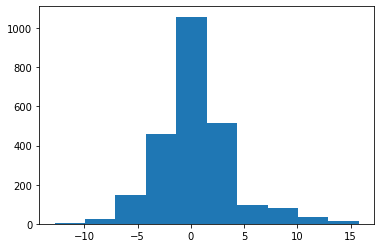

In [12]:
plt.hist(test_y)

(array([5.00e+01, 1.83e+03, 5.00e+02, 5.50e+01, 1.00e+00, 1.00e+00,
        1.00e+00, 2.00e+00, 0.00e+00, 1.00e+00]),
 array([-0.05239091, -0.01911412,  0.01416268,  0.04743947,  0.08071627,
         0.11399306,  0.14726986,  0.18054664,  0.21382344,  0.24710023,
         0.28037703], dtype=float32),
 <BarContainer object of 10 artists>)

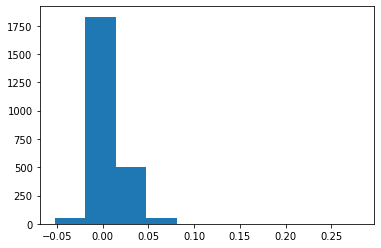

In [13]:
plt.hist(pred)

In [14]:
pd.options.display.max_colwidth = 1000

In [16]:
test_df.sort_values(by='actual', ascending=False).head(25)[['clean_text','pred','actual']]

,clean_text,pred,actual
7056,"replying to @flcnhvy @tesla and @thirdrowtesla ok sure btw, we recruit great engineers from almost anywhere in the world, so this shouldn’t be thought of as usa only. also, work location can be bay area (preferred), but austin (many of our chip designers are there) or potentially any tesla gigafactory.",0.007198,15.780249
7057,replying to @renatakonkoly @nichegamer and @justpaulinelol desperate times call for desperate measures …,0.007198,15.780249
7058,"replying to @cathiedwood @sbarnettark and 2 others first, we need to make it super safe & easy to use, then determine greatest utility vs risk. from initially working to volume production & implantation is a long road. as with vehicle safety, it will be much harder to pass our internal standards than minimum regulatory standards.",0.007198,15.780249
7042,"replying to @astronomiaum only 66 years from first controlled, powered flight to landing on the moon. now, half a century later, we are still unable to return. this must change.",0.007198,15.780249
7055,"replying to @teslagong @elonsbrain and 2 others it will ultimately be used to make up for entire lost sections of the brain due to stroke/accident/congenital. don’t want to get too excited, but the potential is truly transformational for restoring brain & motor functions. there is no other way to do it imo.",0.007198,15.780249
7054,replying to @elonsbrain @cathiedwood and @arkinvest probably this summer,0.007198,15.780249
7059,replying to @dofaquarius @cathiedwood and @arkinvest wait until you see the next version vs what was presented last year. it’s *awesome*.,0.007198,15.780249
7046,replying to @nichegamer the crypto scam level on twitter is reaching new levels. this is not cool.,0.007198,15.780249
7319,replying to @dofaquarius and @ppathole thanks,0.055483,14.128633
7338,replying to @ppathole yes,0.055483,14.128633
